In [21]:
%matplotlib inline

import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from io import StringIO
from sklearn.metrics import mean_squared_error
import glob
import os
from functools import reduce
import numpy as np
import re

In [22]:
def spike_conc(x):
    conc = ''
    if 'LE01' in x:
        conc = '0.1 pg'
    elif re.search('LE1$', x):
        conc = '1 pg'
    elif 'LE100' in x:
        conc = '100 pg'
    elif 'LE1K' in x:
        conc = '1000 pg'
    return conc

def published():
    gene_expr = '/stor/work/Lambowitz/cdw2854/EV_polyA/published_expr/rna_tissue.tsv'
    expr_df = pd.read_table(gene_expr) \
        .pipe(pd.pivot_table, columns = 'Sample', 
              index = ['Gene','Gene name'], values = 'Value')\
        .reset_index()
    return expr_df


def read_salmon(filename, column = 'NumReads'):
    samplename = os.path.basename(os.path.dirname(filename))
    assert(column in ['NumReads','TPM'])
    return pd.read_table(filename)\
        .rename(columns = {column:samplename}) \
        .filter(['Name', samplename])

In [23]:
def salmon_df(quant = 'TPM'):
    assert(quant in ['TPM', 'CPM'])
    column = 'NumReads' if quant == 'CPM' else 'TPM'
    salmon_path = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/salmon_result'
    sample_folders = glob.glob(salmon_path + '/Q*LE*')
    gene_sf = map(lambda x: x + '/quant.genes.sf', sample_folders)
    df = list(map(lambda f: read_salmon(f, column = column), gene_sf))
    df = reduce(lambda x,y: x.merge(y, how = 'outer', on = ['Name']), df)
    return df

cpm_df = salmon_df(quant='CPM')
cpm_df.head()

,Name,Qcf_LE1K,Qcf_LE100,Qcf_LE01,Qcf_LE1
0,ERCC-00171,170.0,221.0,0.0,1.0
1,ERCC-00158,0.0,0.0,0.0,0.0
2,ERCC-00156,0.0,0.0,0.0,0.0
3,ERCC-00150,2.0,1.0,0.0,0.0
4,ERCC-00143,0.0,0.0,0.0,0.0


In [24]:
spike_df = cpm_df\
    .assign(ercc = lambda d: np.where(d.Name.str.contains('ERCC'),
                                       'ERCC',
                                        'Not ERCC')) \
    .pipe(pd.melt, 
          id_vars = ['Name', 'ercc'],
         var_name = 'samplename',
         value_name = 'cpm') \
    .assign(cpm = lambda d: d.groupby('samplename').cpm.transform(lambda x: 1e6*x/x.sum()))\
    .groupby(['samplename','ercc'], as_index=False)\
    .agg({'cpm':'sum'}) \
    .assign(ercc_fraction = lambda d: d.groupby('samplename')['cpm'].transform(lambda x: x/x.sum()))  \
    .query('ercc == "ERCC"') \
    .assign(conc_label = lambda d: d.samplename.map(spike_conc)) \
    .assign(conc = lambda d: d.conc_label.str.replace(' pg','').astype(float)) \
    .assign(log_cpm = lambda d: np.log10(d.cpm+1))\
    .assign(log_conc = lambda d: np.log10(d.conc)) \
    .assign(mRNA_conc = lambda d: d.conc/d.ercc_fraction - d.conc ) \
    .assign(log_mRNA = lambda d: np.log10(d.mRNA_conc)) \
    .assign(log_mRNA_cpm = lambda d: np.log10((1-d.ercc_fraction) * 1e6))
spike_df

,samplename,ercc,cpm,ercc_fraction,conc_label,conc,log_cpm,log_conc,mRNA_conc,log_mRNA,log_mRNA_cpm
0,Qcf_LE01,ERCC,113.120031,0.000113,0.1 pg,0.1,2.057362,-1.0,883.916734,2.946411,5.999951
2,Qcf_LE1,ERCC,1015.545986,0.001016,1 pg,1.0,3.007127,0.0,983.691992,2.992859,5.999559
4,Qcf_LE100,ERCC,151688.468149,0.151688,100 pg,100.0,5.180955,2.0,559.245895,2.747603,5.928555
6,Qcf_LE1K,ERCC,409206.086859,0.409206,1000 pg,1000.0,5.611943,3.0,1443.756415,3.159494,5.771436


In [27]:
def forward(x, m_m):
    return torch.log(x) + torch.log(m_m)

$\pi_{ercc} = \frac{m_e}{m_e+m_m}$

$ (1-\pi_{ercc} )(m_e) = \pi_{ercc} m_m $

Take $log$ and add a error term ($\epsilon$) for optimization:

$ log(1-\pi_{ercc}) + log(m_e) = log(\pi_{ercc}) + log(m_m) + \epsilon$

$ \epsilon(m_m) = log(1-\pi_{ercc}) + log(m_e) - log(\pi_{ercc}) - log(m_m) $

$ L(m_m) = MSE(m_m) = \sum_{i\in(0.1,1,100,1000)} \epsilon(i; m_m)   $

where $\pi_{ercc}$ is the fraction ERCC read count, $m_e$ is the amount (pg/4-ml plasma) of ERCC spike-ins and $m_m$ is the amount (pg/4-ml plasma) of mRNA

In [41]:
ercc_fraction = torch.tensor(spike_df.ercc_fraction.values)
ercc_conc = torch.tensor(spike_df.conc.values)
y = torch.log(1-ercc_fraction) + torch.log(ercc_conc)
m_m = torch.rand(1, requires_grad=True)
loss_function = torch.nn.MSELoss()
lr = 0.05
optimizer = torch.optim.Adam([m_m], lr = lr)
losses = []
mRNA = []

for epoch in range(100000):
    pred_y = forward(ercc_fraction.float(), m_m)
    loss = loss_function(pred_y.float(), y.float())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    # record
    loss_value = float(loss.data)
    mRNA.append(float(m_m.data[0]))
    losses.append(loss_value)

/stor/work/Lambowitz/cdw2854/src/miniconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


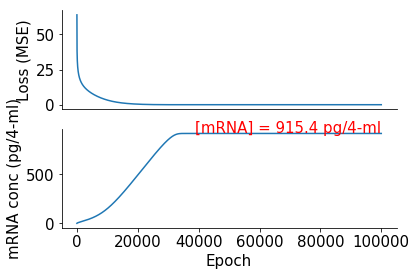

In [42]:
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
ax = plt.subplot(211)
ax.plot(losses)
ax.set_ylabel('Loss (MSE)')
ax.xaxis.set_visible(False)
ax = plt.subplot(212)
ax.plot(mRNA)
ax.text(x = len(mRNA) + 100, 
        y = mRNA[-1] + 10, 
        s = '[mRNA] = %.1f pg/4-ml' %(mRNA[-1]), color = 'red',
       ha = 'right', fontsize=15)
ax.set_ylabel('mRNA conc (pg/4-ml)')
ax.set_xlabel('Epoch')
sns.despine()